In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [52]:
# Carga de archivos

df_clientes = pd.read_csv(r"data/clean/clientes.csv")
df_productos = pd.read_csv(r"data/clean/productos.csv")
df_ventas = pd.read_csv(r"data/clean/ventas.csv")
df_detalle = pd.read_csv(r"data/clean/detalle_ventas.csv")
df_features = pd.read_csv(r"data/clean/features_RFM.csv")

In [53]:
df_features = df_features.rename(columns={"cluster": "segmento"})

# Segmentación RFM

Hemos completado la clasificación de nuestra base de clientes utilizando el modelo RFM (Recencia, Frecuencia, Valor Monetario), segmentando a nuestros compradores en cuatro grupos estratégicos: 
- **Fieles**: Representan nuestro segmento más valioso, garantizando la mayor parte de nuestros ingresos y deben ser premiados y retenidos.
- **En Ascenso**: Estos son nuestra principal oportunidad de crecimiento, son clientes activos a los que debemos motivar para que aumenten su frecuencia de compra y se conviertan en Fieles.
- **En Alerta**: Son clientes que solían comprar, pero su Recencia ha caído significativamente.
- **Congelados**: Representan clientes inactivos que no han comprado en un largo periodo.

Esta nueva segmentación nos proporciona un mapa claro sobre dónde debemos invertir nuestros recursos de marketing.

In [54]:
df_features.groupby('segmento').agg(clientes=("id_cliente", "count"),
                                   recency_dias_promedio=("recency_dias", "mean"),
                                   frequency_promedio=("frequency", "mean"),
                                   monetary_promedio=("monetary", "mean")).round(2).reset_index()

,segmento,clientes,recency_dias_promedio,frequency_promedio,monetary_promedio
0,0,1075,21.34,29.03,199755.14
1,1,268,2.29,194.39,1328058.30
2,2,127,469.66,1.00,6376.76
3,3,61,1.34,499.16,3553900.56


#### **Segmento 0: "En Alerta"**

Recencia: 21 días. A pesar de haber comprado bastante (29 veces), 21 días es el límite donde el cliente empieza a "olvidar" el mini-market.

Frecuencia y Valor: Media/Baja. Aunque han gastado y comprado más que los Congelados, su valor es bajo comparado con los otros.

Conclusión: Este es el segmento de mayor riesgo e impacto. Representan una fuga de ingresos potencial masiva si no se detiene a tiempo.

#### **Segmento 1: "En Ascenso"**

Recencia: 2 días. Son extremadamente recientes.

Frecuencia y Valor: Altos (194 veces, 1.3M). Su frecuencia y gasto ya son significativos, lo que demuestra un alto nivel de lealtad.

Conclusión: Son nuestros Potenciales Campeones. La inversión en ellos debe enfocarse en programas de lealtad de nivel superior que los premien para subir al Cluster 3.

#### **Segmento 2: "Congelados"**

Recencia: 470 días (más de un año).

Frecuencia y Valor: 1 compra, $6,377.

Conclusión: Mantenerlos en la lista de bajo coste. Solo enviarles campañas masivas y muy económicas (ej. correos genéricos de ofertas estacionales) y enfocarnos en los grupos de mayor rentabilidad.

#### **Segmento 3: "Fieles"**

Recencia: 1 día.

Frecuencia y Valor: 499 veces, $3.5M.

Conclusión: El foco es Retención Cero Fugas. Debemos tratarlos como VIP, buscar su opinión constantemente (para mejorar la tienda) y utilizarlos como fuente de referidos y de validación de nuevos productos.

#### **Conclusión**
Como demuestran los resultados, tenemos una base de clientes con altos niveles de compromiso: el 96% del Valor Monetario total proviene de los segmentos 'En Ascenso' y 'Fieles', a pesar de que representan solo el 21% de nuestra base de datos (329 clientes). Esta élite es la que sostiene la rentabilidad de Los Latinos y debe ser nuestra máxima prioridad. Sin embargo, nuestro mayor riesgo reside en el Cluster 'En Alerta'. Con 1,075 clientes, este grupo es el más numeroso y su Recencia promedio de 21 días indica que están al borde de la inactividad. Si no implementamos una estrategia de reactivación urgente, corremos el riesgo de que esta gran masa de clientes se convierta en 'Congelados', erosionando gravemente nuestra base activa.

# Análisis de Segmentos

In [55]:
# Unimos la tabla ventas con la tabla de features para obtener el segmento de cada cliente
df_ventas_seg = df_ventas.merge(df_features[['id_cliente', 'segmento']], on='id_cliente', how='left')

# Creamos columnas de añomes y dia de la semana para el analisis temporal
df_ventas_seg['añomes'] = pd.to_datetime(df_ventas_seg['fecha']).dt.to_period('M')
df_ventas_seg['diasem'] = pd.to_datetime(df_ventas_seg['fecha']).dt.dayofweek

## Segmento 0: "En Alerta"

In [56]:
# Filtramos las ventas del segmento 0
segmento = 0
ventas_seg = df_ventas_seg[df_ventas_seg['segmento'] == segmento].copy()

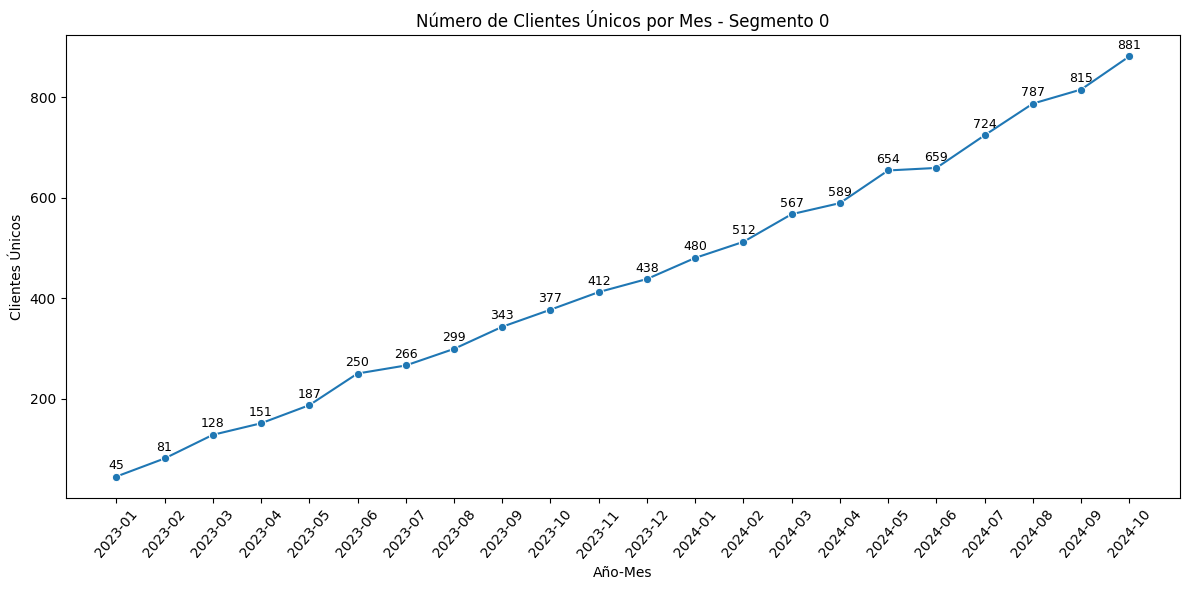

In [57]:
clientes = ventas_seg.groupby('añomes')['id_cliente'].nunique()

plt.figure(figsize=(12, 6))
sns.lineplot(x=clientes.index.astype(str), y=clientes.values, marker='o')


offset = max(clientes.values) * 0.01
for i, (x, y) in enumerate(zip(clientes.index.astype(str), clientes.values)):
    plt.text(i, y + offset, str(y), ha='center', va='bottom', fontsize=9)

plt.title('Número de Clientes Únicos por Mes - Segmento 0')
plt.xlabel('Año-Mes')
plt.ylabel('Clientes Únicos')
plt.xticks(rotation=50)
plt.tight_layout()
plt.show()

Se observa un **crecimiento exponencial sostenido** en la base de clientes del minimarket "Los Latinos", con los siguientes hallazgos:

- **Crecimiento total**: De 45 clientes (enero 2023) a 881 clientes (octubre 2024), representando un **incremento de 1,858%** (19.6x) en 22 meses
- **Tasa de crecimiento mensual promedio**: ~40 clientes nuevos netos por mes
- **Tendencia**: La curva muestra crecimiento acelerado sin señales de desaceleración o plateau, indicando expansión saludable del negocio

### Mapa de calor de Ventas por Día de Semana y Mes

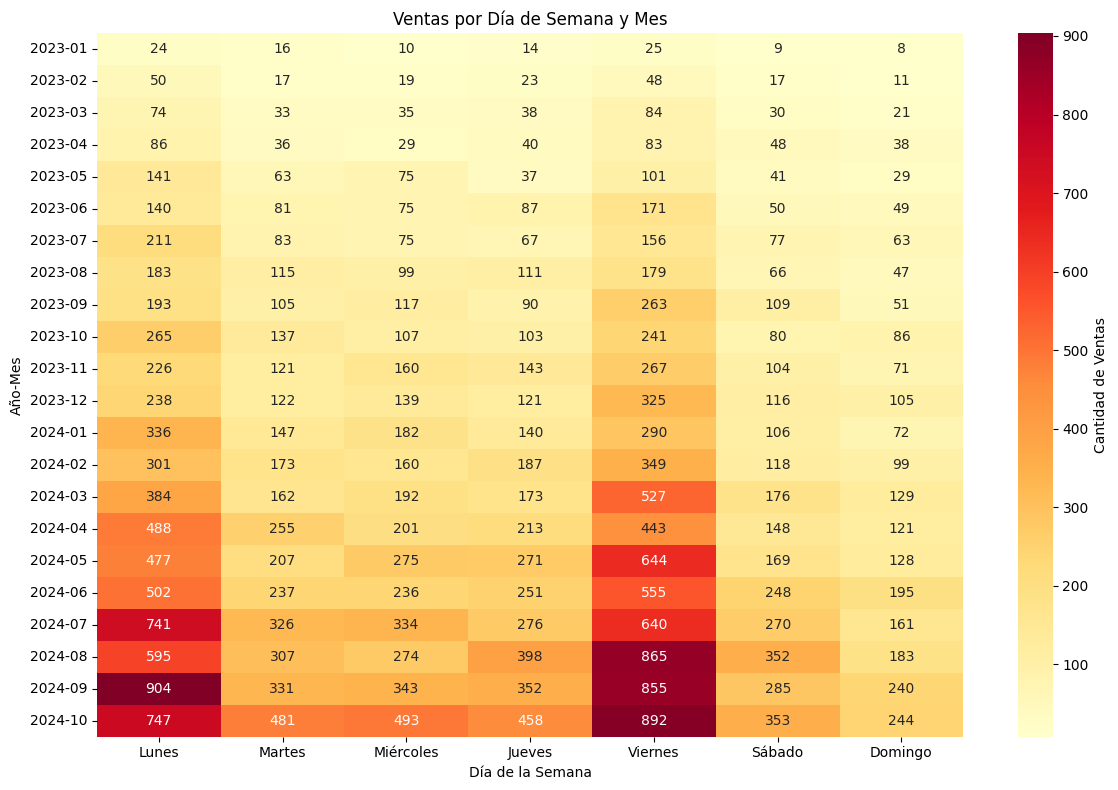

In [58]:
# Definir nombres de los días
dias_nombres = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

# Agregar ventas por mes y día de semana
ventas_heatmap = ventas_seg.groupby(['añomes', 'diasem']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(ventas_heatmap, annot=True, fmt='d', cmap='YlOrRd', 
            xticklabels=dias_nombres, cbar_kws={'label': 'Cantidad de Ventas'})
plt.title('Ventas por Día de Semana y Mes')
plt.xlabel('Día de la Semana')
plt.ylabel('Año-Mes')
plt.tight_layout()
plt.show()

Este heatmap revela patrones temporales claros en el comportamiento de compra del minimarket "Los Latinos":

**Crecimiento y Escala:**
- **Expansión dramática**: De 106 ventas totales (enero 2023) a 3,668 ventas (octubre 2024), un incremento de **3,360%**
- **Pico absoluto**: Viernes de septiembre 2024 con 892 ventas
- **Aceleración notable**: Los últimos 4 meses (jul-oct 2024) concentran los volúmenes más altos históricos

**Patrón Semanal Consistente:**
- **Lunes y Viernes dominan**: Representan ~35-40% de ventas semanales, con Lunes alcanzando hasta 904 ventas
- **Domingo es el día más débil**: Consistentemente 50-70% menos ventas que los días pico
- **Mid-week estable**: Martes-Jueves mantienen volúmenes intermedios predecibles (~200-450 ventas)

**Correlación Temporal:**
- Todos los días crecen simultáneamente, indicando que factores externos (estacionalidad, campañas) impactan uniformemente
- Las proporciones relativas entre días se mantienen constantes (Lunes/Viernes ~2.5x Domingo)

### Evolución de Ventas Diarias por Día de Semana

In [59]:
fecha_corte = pd.to_datetime('2024-10-31')

ventas_dia = ventas_seg.groupby([pd.to_datetime(ventas_seg['fecha']).dt.date, 'diasem']).size().reset_index(name='ventas')
ventas_dia['fecha'] = pd.to_datetime(ventas_dia['fecha'])
ventas_dia['dia_nombre'] = ventas_dia['diasem'].map(dict(enumerate(dias_nombres)))

fig = px.scatter(ventas_dia, x='fecha', y='ventas', color='dia_nombre',
                 facet_col='dia_nombre', facet_col_wrap=4,  # ✅ Cambio aquí
                 title='Evolución de Ventas Diarias por Día de Semana (2023-2024)',
                 labels={'ventas': 'Cantidad de Ventas', 'fecha': 'Fecha'},
                 category_orders={'dia_nombre': dias_nombres},  # ✅ Orden por nombres
                 height=800)

# Agregar línea vertical en todos los subgráficos
fig.add_vline(x=fecha_corte, line_dash="dash", line_color="red", 
              line_width=2, opacity=0.7)

fig.update_layout(showlegend=False)

fig.show()

Este gráfico muestra la evolución diaria de ventas segmentada por día de semana. Se observa:

- **Crecimiento sostenido**: Todos los días muestran tendencia ascendente clara desde 2023 hasta 2024
- **Patrón semanal**: Lunes (~230 ventas) y Viernes (~240 ventas) son los días más fuertes. Domingo (~80 ventas) es el más débil
- **Línea roja (25-Oct-2024)**: Fecha de comparación contra la recencia.

### Estrategias

Objetivo Estratégico: Reactivación Urgente y Alineación con Días Pico. Moverlos de la Recencia de 21 días a < 7 días, enfocando el rescate en los días fuertes (Lunes y Viernes).

**Estrategia 1:** Rescate Basado en Patrones

Tácticas de Marketing Adaptadas (Alineadas con el Contexto): Oferta "Viernes de Regreso": Enviar el cupón de alto valor (ej. 15% de descuento) solo los miércoles o jueves. El cupón solo puede ser canjeado los Viernes, que es el día de mayor pico de ventas (892 ventas en Septiembre '24).

Justificación (Basada en los Gráficos): Alinea la reactivación con el día de mayor potencial de gasto, aprovechando el alto tráfico para asegurar que el cliente regrese en un momento de "clímax" comercial.

**Estrategia 2:** Incentivo del Lunes

Tácticas de Marketing Adaptadas (Alineadas con el Contexto): "Lunes de Stock Fresco" (o Post-Fin de Semana): Ofrecer un pequeño regalo (snack o bebida) si el cliente En Alerta compra el día Lunes.

Justificación (Basada en los Gráficos): El lunes es el segundo día más fuerte (hasta 904 ventas). Esto capitaliza el inicio de semana, cuando los clientes probablemente reabastecen sus despensas.

**Estrategia 3:** Campañas de Micro-Segmentación Temporal

Tácticas de Marketing Adaptadas (Alineadas con el Contexto): Segmentación por Tasa de Crecimiento: Analizar qué clientes del Cluster 0 compraron en los picos de Julio-Octubre 2024 (donde hubo aceleración notable) y dirigirles la oferta de regreso primero.

Justificación (Basada en los Gráficos): La aceleración notable indica que la tienda estuvo de moda. Apuntar a los que compraron en ese peak puede ser más fácil de reactivar, pues ya experimentaron el valor de la tienda en su mejor momento.

**Estrategia 4:** Optimización de Recursos

Tácticas de Marketing Adaptadas (Alineadas con el Contexto): Exclusión del Domingo: Evitar cualquier inversión en este grupo para incentivarlos a comprar los Domingos, ya que es el día más débil (50-70% menos ventas) y el ROI sería bajo.

Justificación (Basada en los Gráficos): Optimiza los recursos al no forzar el tráfico en días de baja demanda, enfocándose donde el cliente ya está acostumbrado a comprar.

**Estrategia 5:** Medición de Impacto

Tácticas de Marketing Adaptadas (Alineadas con el Contexto): El dashboard de Power BI debe rastrear la Recencia (R) de los clientes reactivados, asegurándose de que la media del cluster baje de 21 días a un número < 7 días post-campaña.

Justificación (Basada en los Gráficos): Garantiza que la estrategia está cumpliendo el objetivo principal de la segmentación.

Conclusión Ajustada:
La clave para el Cluster 0 es utilizar la fuerza operativa (Lunes y Viernes) como palanca de reactivación, en lugar de dispersar las ofertas. Al vincular el cupón de rescate de alto valor (15%) a los días de alto tráfico, garantizas que la inversión de marketing no solo trae de vuelta al cliente, sino que lo hace cuando el mini-market está en su mejor momento comercial.


## Segmento 1: "En Ascenso"

In [60]:
# Filtramos las ventas del segmento 1
segmento = 1
ventas_seg = df_ventas_seg[df_ventas_seg['segmento'] == segmento].copy()

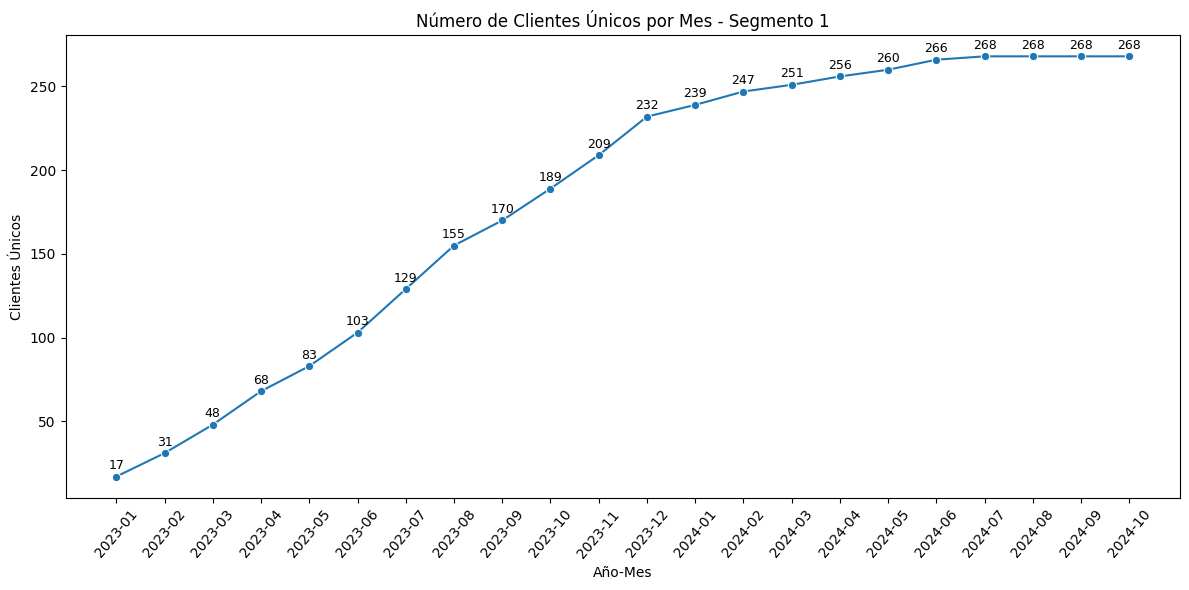

In [61]:
clientes = ventas_seg.groupby('añomes')['id_cliente'].nunique()

plt.figure(figsize=(12, 6))
sns.lineplot(x=clientes.index.astype(str), y=clientes.values, marker='o')


offset = max(clientes.values) * 0.01
for i, (x, y) in enumerate(zip(clientes.index.astype(str), clientes.values)):
    plt.text(i, y + offset, str(y), ha='center', va='bottom', fontsize=9)

plt.title(f'Número de Clientes Únicos por Mes - Segmento {segmento}')
plt.xlabel('Año-Mes')
plt.ylabel('Clientes Únicos')
plt.xticks(rotation=50)
plt.tight_layout()
plt.show()

Se observa un **crecimiento sostenido con estabilización reciente** en la base de clientes del minimarket "Los Latinos", con los siguientes hallazgos:

- **Crecimiento total**: De 17 clientes (enero 2023) a 268 clientes (octubre 2024), representando un **incremento de 1,476%** (15.8x) en 22 meses
- **Tasa de crecimiento mensual promedio**: ~11 clientes nuevos netos por mes (4x menor que Segmento 0)
- **Plateau identificado**: La base de clientes se ha **estabilizado en ~268 clientes** desde julio 2024, sin crecimiento adicional en los últimos 4 meses
- **Tendencia**: Curva de crecimiento típica en forma de "S" con fase de madurez alcanzada, sugiriendo **saturación del mercado objetivo** o límite de capacidad operativa

### Mapa de calor de Ventas por Día de Semana y Mes

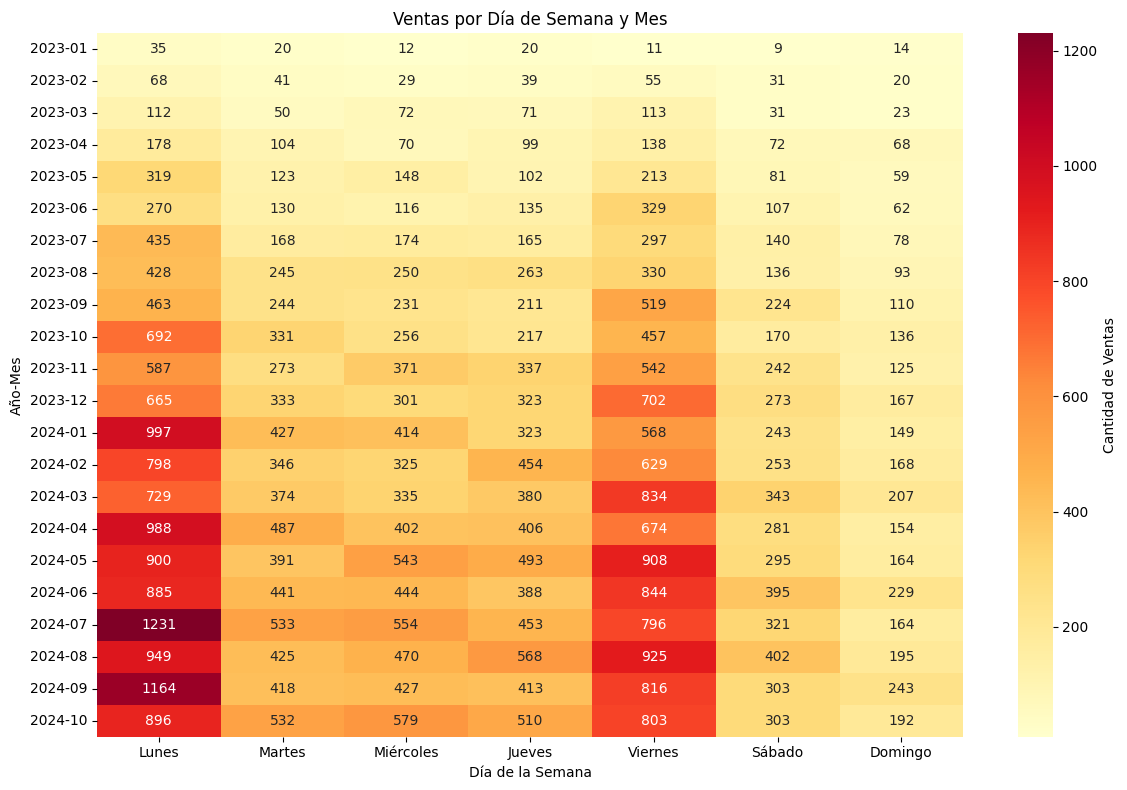

In [62]:
# Definir nombres de los días
dias_nombres = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

# Agregar ventas por mes y día de semana
ventas_heatmap = ventas_seg.groupby(['añomes', 'diasem']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(ventas_heatmap, annot=True, fmt='d', cmap='YlOrRd', 
            xticklabels=dias_nombres, cbar_kws={'label': 'Cantidad de Ventas'})
plt.title('Ventas por Día de Semana y Mes')
plt.xlabel('Día de la Semana')
plt.ylabel('Año-Mes')
plt.tight_layout()
plt.show()

Este heatmap revela patrones temporales en el comportamiento de compra del minimarket "Los Latinos":

**Crecimiento y Escala:**
- **Expansión significativa**: De 121 ventas totales (enero 2023) a 3,815 ventas (octubre 2024), un incremento de **3,053%**
- **Pico absoluto**: Lunes de septiembre 2024 con 1,164 ventas
- **Volumen superior**: Este segmento genera ~4% más ventas que Segmento 0 (Aurelion) a pesar de tener solo 30% de los clientes

**Patrón Semanal Distintivo:**
- **Lunes EXTREMADAMENTE dominante**: Representa ~30-35% de ventas semanales (vs ~25% en Segmento 0), alcanzando hasta 1,231 ventas
- **Viernes segundo lugar fuerte**: Mantiene volúmenes altos (~800-900 ventas) pero notablemente por debajo de Lunes
- **Domingo sigue siendo el más débil**: Consistentemente ~15-20% del volumen de Lunes
- **Distribución más concentrada**: Mayor diferencia entre día pico y valle que en Segmento 0

**Correlación Temporal:**
- Todos los días crecen simultáneamente, con aceleración notable en 2024
- Proporciones relativas se mantienen: Lunes ~4-5x Domingo (vs 2.5x en Segmento 0)

### Evolución de Ventas Diarias por Día de Semana

In [63]:
fecha_corte = pd.to_datetime('2024-10-31')

ventas_dia = ventas_seg.groupby([pd.to_datetime(ventas_seg['fecha']).dt.date, 'diasem']).size().reset_index(name='ventas')
ventas_dia['fecha'] = pd.to_datetime(ventas_dia['fecha'])
ventas_dia['dia_nombre'] = ventas_dia['diasem'].map(dict(enumerate(dias_nombres)))

fig = px.scatter(ventas_dia, x='fecha', y='ventas', color='dia_nombre',
                 facet_col='dia_nombre', facet_col_wrap=4,  # ✅ Cambio aquí
                 title='Evolución de Ventas Diarias por Día de Semana (2023-2024)',
                 labels={'ventas': 'Cantidad de Ventas', 'fecha': 'Fecha'},
                 category_orders={'dia_nombre': dias_nombres},  # ✅ Orden por nombres
                 height=800)

# Agregar línea vertical en todos los subgráficos
fig.add_vline(x=fecha_corte, line_dash="dash", line_color="red", 
              line_width=2, opacity=0.7)

fig.update_layout(showlegend=False)

fig.show()

Este gráfico muestra la evolución diaria de ventas segmentada por día de semana. Se observa:

- **Crecimiento sostenido**: Todos los días muestran tendencia ascendente clara desde 2023 hasta 2024
- **Patrón semanal**: Lunes (~270 ventas) domina ampliamente, seguido de Viernes (~220 ventas). Domingo (~60 ventas) es el más débil. Las proporciones se mantienen constantes con Lunes representando ~4.5x las ventas de Domingo

### Estrategias

Objetivo Estratégico: Defensa contra la Competencia y Aumento del Ticket Promedio (Up-selling/Cross-selling) para asegurar que migren al cluster Fieles.

**Estrategia 1**: Defensa Estratégica del Lunes

Tácticas de Marketing Adaptadas (Alineadas con el Contexto): "Lunes de Mayorista": Crear una oferta recurrente solo para el Lunes que premie la compra de volumen (ej. "Lleva 3 unidades de productos esenciales y obtén el 10% de descuento").

Justificación (Basada en los Gráficos): El Lunes es su día más fuerte, indicando una compra de reabastecimiento semanal importante. La estrategia busca maximizar el valor de esa visita crítica y monopolizar su compra de inicio de semana.

**Estrategia 2**: Incentivo de Extensión Semanal

Tácticas de Marketing Adaptadas (Alineadas con el Contexto): Cupón de "Mid-Week Break": Entregarles un cupón en la caja el Lunes, canjeable solo Martes o Miércoles. El descuento es para productos complementarios o de impulso (snacks, bebidas).

Justificación (Basada en los Gráficos): Rompe el patrón de concentración de compra y busca aumentar la frecuencia semanal (F) sin canibalizar su gran compra de los Lunes.

**Estrategia 3**: Monitoreo de Plateau y Fidelización

Tácticas de Marketing Adaptadas (Alineadas con el Contexto): Programa "Next Level": Enviar una comunicación personalizada identificando su estancamiento (plateau). Ofrecerles un desafío para subir al Club Platino (Fieles) que se centre en aumentar el Ticket Promedio o añadir una categoría nueva de producto a su compra.

Justificación (Basada en los Gráficos): Su base de clientes está estancada en 268. Esto exige un esfuerzo concentrado para asegurar que los clientes que ya están en el cluster se muevan hacia arriba, defendiendo el volumen que generan.

**Estrategia 4**: Análisis de Carrito

Tácticas de Marketing Adaptadas (Alineadas con el Contexto): Cross-selling Inteligente: Analizar qué artículos de alto margen compran los Fieles y que los En Ascenso no compran. Dirigir mensajes específicos de ese producto (ej. si no compran licores importados, ofrecer un 10% de descuento en esa categoría).

Justificación (Basada en los Gráficos): Aprovechar su alto volumen de compra (194 veces) para introducir nuevos productos y aumentar el Valor Monetario (V).

Conclusión Ajustada:
El Cluster 1 es el motor de volumen actual. La estrategia debe ser altamente defensiva en su día pico (Lunes) y ambiciosa en el aumento del Valor Monetario, ya que la frecuencia es ya muy alta. La inversión en este grupo es de alto retorno, enfocada en monopolizar su compra de inicio de semana y llevar su Valor Monetario de $1.3M a los $3.5M del Cluster 3.


## Segmento 2: "Congelados"

In [64]:
# Filtramos las ventas del segmento 2
segmento = 2
ventas_seg = df_ventas_seg[df_ventas_seg['segmento'] == segmento].copy()

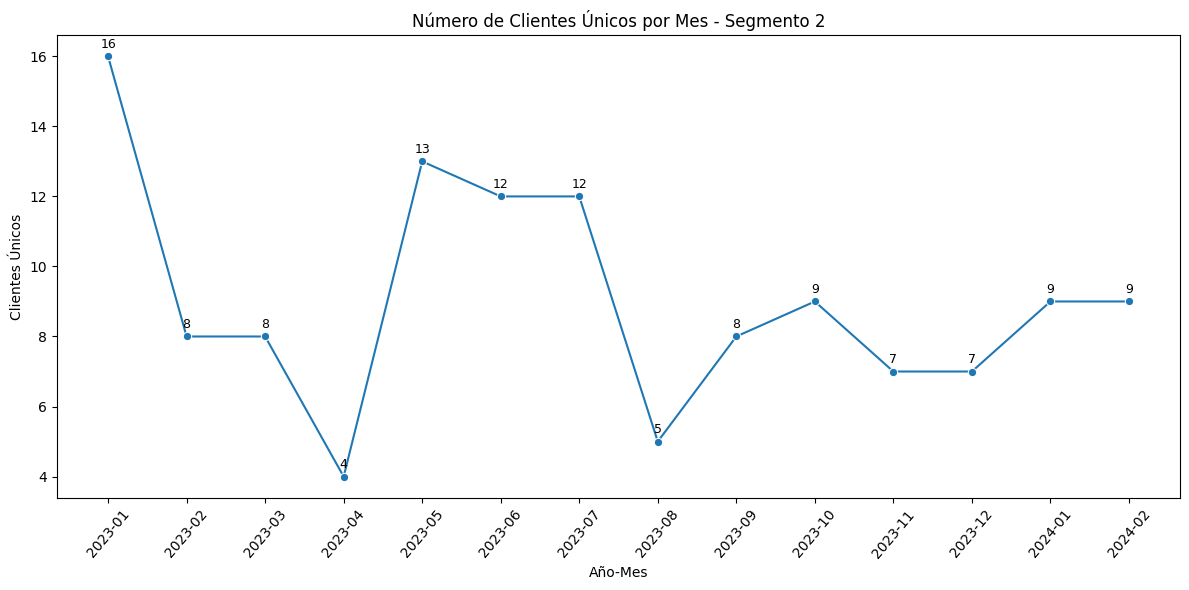

In [65]:
clientes = ventas_seg.groupby('añomes')['id_cliente'].nunique()

plt.figure(figsize=(12, 6))
sns.lineplot(x=clientes.index.astype(str), y=clientes.values, marker='o')


offset = max(clientes.values) * 0.01
for i, (x, y) in enumerate(zip(clientes.index.astype(str), clientes.values)):
    plt.text(i, y + offset, str(y), ha='center', va='bottom', fontsize=9)

plt.title(f'Número de Clientes Únicos por Mes - Segmento {segmento}')
plt.xlabel('Año-Mes')
plt.ylabel('Clientes Únicos')
plt.xticks(rotation=50)
plt.tight_layout()
plt.show()

**Número de Clientes Únicos por Mes - Segmento 2**

Se observa un **patrón altamente volátil y sin tendencia clara** en la base de clientes del Segmento 2, con los siguientes hallazgos:

- **Base extremadamente pequeña**: Oscila entre 4 y 16 clientes únicos por mes durante todo el período analizado
- **Alta volatilidad**: Fluctuaciones drásticas mes a mes (ej: de 16 clientes en ene-2023 a 4 en abr-2023, luego sube a 13 en may-2023)
- **Sin crecimiento neto**: Después de 22 meses, la base se mantiene en 9 clientes (feb-2024), similar al promedio histórico de ~9 clientes
- **Estabilización reciente**: Los últimos 2 meses (ene-feb 2024) muestran estabilidad en 9 clientes, sin cambios

### Mapa de calor de Ventas por Día de Semana y Mes

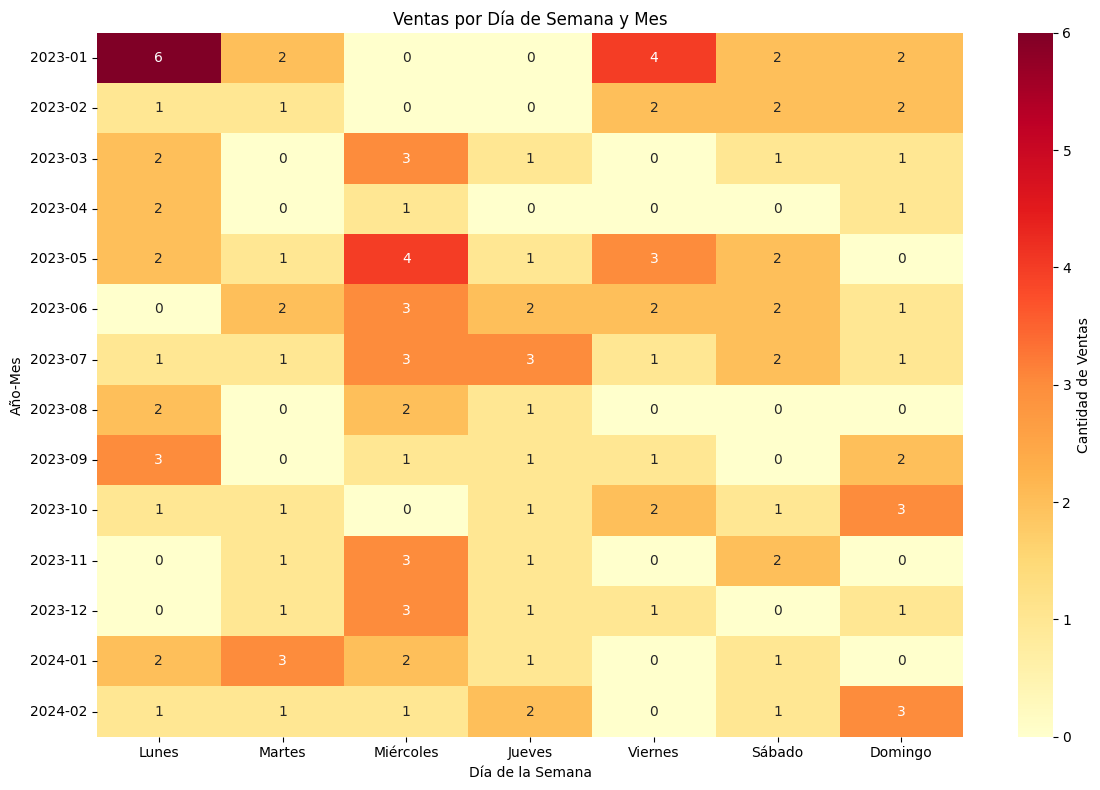

In [66]:
# Definir nombres de los días
dias_nombres = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

# Agregar ventas por mes y día de semana
ventas_heatmap = ventas_seg.groupby(['añomes', 'diasem']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(ventas_heatmap, annot=True, fmt='d', cmap='YlOrRd', 
            xticklabels=dias_nombres, cbar_kws={'label': 'Cantidad de Ventas'})
plt.title('Ventas por Día de Semana y Mes')
plt.xlabel('Día de la Semana')
plt.ylabel('Año-Mes')
plt.tight_layout()
plt.show()

**Ventas por Día de Semana y Mes - Segmento 2**

Este heatmap revela un **segmento marginal con actividad mínima y errática**:

**Escala y Volumen:**
- **Ventas extremadamente bajas**: Máximo de 6 ventas en un solo día (ene-2023), con promedio de ~1 venta/día
- **Actividad limitada**: Los datos muestran solo hasta feb-2024, sugiriendo posible descontinuación o inactividad posterior
- **Muchos días sin ventas**: Celdas en 0 abundantes, indicando operación intermitente o esporádica
- **Volumen total insignificante**: <0.5% comparado con Segmentos 0 y 1

**Ausencia de Patrón Semanal:**
- **Sin día dominante claro**: A diferencia de otros segmentos, no hay concentración en Lunes o Viernes
- **Distribución aleatoria**: Las ventas aparecen dispersas sin lógica aparente de día preferido
- **Lunes (ene-2023)**: Único pico notable con 6 ventas, sin repetirse posteriormente

**Sin Correlación Temporal:**
- No se observa crecimiento ni tendencia direccional
- La actividad no responde a patrones estacionales o de mercado
- Comportamiento independiente de los otros segmentos

### Evolución de Ventas Diarias por Día de Semana

In [67]:
fecha_corte = pd.to_datetime('2024-10-31')

ventas_dia = ventas_seg.groupby([pd.to_datetime(ventas_seg['fecha']).dt.date, 'diasem']).size().reset_index(name='ventas')
ventas_dia['fecha'] = pd.to_datetime(ventas_dia['fecha'])
ventas_dia['dia_nombre'] = ventas_dia['diasem'].map(dict(enumerate(dias_nombres)))

fig = px.scatter(ventas_dia, x='fecha', y='ventas', color='dia_nombre',
                 facet_col='dia_nombre', facet_col_wrap=4,  # ✅ Cambio aquí
                 title='Evolución de Ventas Diarias por Día de Semana (2023-2024)',
                 labels={'ventas': 'Cantidad de Ventas', 'fecha': 'Fecha'},
                 category_orders={'dia_nombre': dias_nombres},  # ✅ Orden por nombres
                 height=800)

# Agregar línea vertical en todos los subgráficos
fig.add_vline(x=fecha_corte, line_dash="dash", line_color="red", 
              line_width=2, opacity=0.7)

fig.update_layout(showlegend=False)

fig.show()


Este gráfico muestra la evolución diaria de ventas segmentada por día de semana. Se observa:

- **Actividad marginal y esporádica**: Máximo de 3 ventas en un día (Martes), con la mayoría de días registrando solo 1 venta
- **Sin correlación entre días**: A diferencia de Segmentos 0 y 1, los días NO se mueven juntos. Cada día opera de manera independiente sin responder a factores comunes
- **Ausencia de patrón semanal**: No hay concentración en días específicos. Lunes, Miércoles y Viernes muestran actividad similar (~1-2 ventas), sin día dominante
- **Sin tendencia de crecimiento**: Los puntos permanecen en el mismo nivel durante todo el período, sin progresión ascendente visible
- **Datos limitados**: La actividad cesa aparentemente a principios de 2024, con ausencia total de datos posteriores
- **Línea roja (25-Oct-2024)**: Marca sin relevancia dado que no hay actividad cercana a esa fecha

### Estrategias

Objetivo Estratégico: Optimización de Costos y "Último Intento" de Bajo Riesgo. Minimizar el gasto de marketing y asegurar que estos clientes no consuman recursos valiosos.

**Estrategia 1**: "Último Disparo" de Email Masivo

Tácticas de Marketing Adaptadas (Alineadas con el Contexto): Campaña de Reactivación de Bajísimo Costo: Enviar un único email o WhatsApp no-promocional (si el costo es $0) que muestre el crecimiento exponencial de la tienda (ej. "¡Mira cuánto hemos crecido! Vuelve a visitarnos.")

Justificación (Basada en los Gráficos): Dado que no hay patrón, no se justifica un cupón de alto valor. Se apela a la novedad y al bajo costo de contacto para intentar una compra de reactivación.

**Estrategia 2**: Exclusión de Canales Costosos

Tácticas de Marketing Adaptadas (Alineadas con el Contexto): Desactivación de SMS/Llamadas: Eliminar al Cluster 2 de cualquier campaña de pago por mensaje (SMS, WhatsApp Business con costo) y de las listas para llamadas de telemarketing.

Justificación (Basada en los Gráficos): La Recencia de 470 días y la Frecuencia de 1 indican que el cliente está perdido. El costo de adquisición (CAC) o reactivación para este grupo es prohibitivo y no se justifica.

**Estrategia 3**: Limpieza de Base de Datos

Tácticas de Marketing Adaptadas (Alineadas con el Contexto): Filtro de Exclusión en Futuras Campañas: Asegurar que, después de este "último disparo", el Cluster 2 sea excluido automáticamente de todas las campañas dirigidas a En Alerta o En Ascenso.

Justificación (Basada en los Gráficos): Optimización de Recursos: Dirigir los presupuestos de marketing (que ya son escasos en un mini-market) a los segmentos 0, 1 y 3, que sí tienen potencial de retorno.


**Estrategia 4**: Medición de Impacto

Tácticas de Marketing Adaptadas (Alineadas con el Contexto): El único KPI relevante es el Número Bruto de Clientes Reactivados. Si la tasa es inferior al 1%, se confirma la decisión de exclusión.
Justificación (Basada en los Gráficos): Permite medir el éxito del último intento antes de declararlos "irrecuperables" para propósitos de marketing directo.


Conclusión Ajustada:
El Cluster 2, Congelados, no exhibe patrones ni volumen que justifiquen una inversión en marketing personalizado. La estrategia para este grupo no es reactivación, sino optimización financiera. Debemos mantener el foco del presupuesto en el rescate masivo del Cluster 0 y la defensa/crecimiento de los Clusters 1 y 3, que son el motor del negocio.


## Segmento 3: "Fieles"

In [68]:
# Filtramos las ventas del segmento 3
segmento = 3
ventas_seg = df_ventas_seg[df_ventas_seg['segmento'] == segmento].copy()

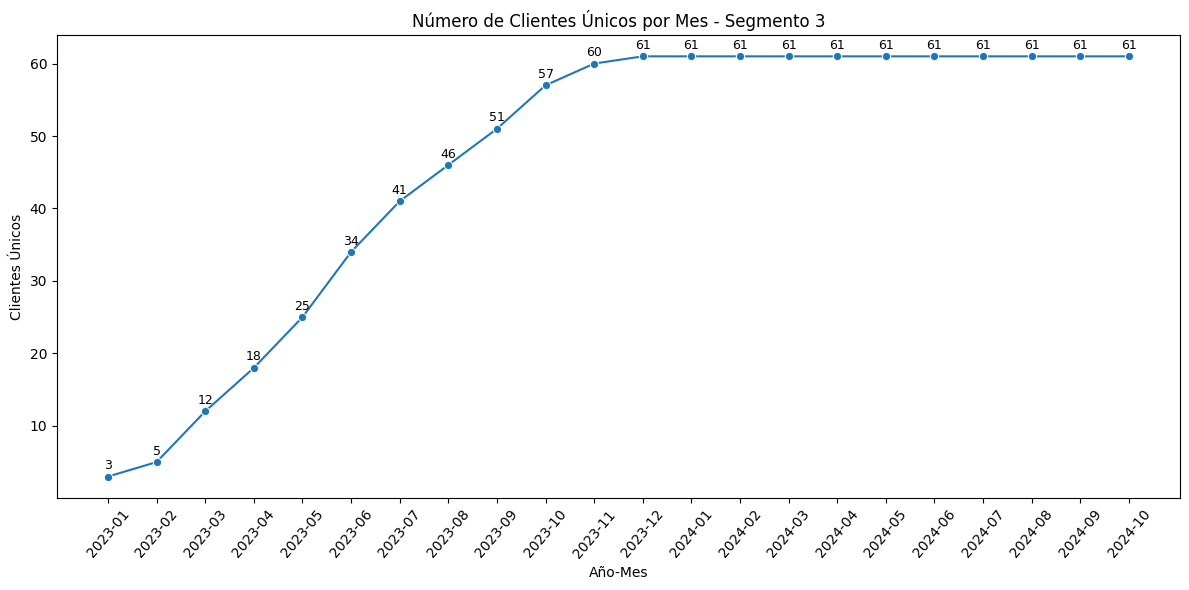

In [69]:
clientes = ventas_seg.groupby('añomes')['id_cliente'].nunique()

plt.figure(figsize=(12, 6))
sns.lineplot(x=clientes.index.astype(str), y=clientes.values, marker='o')


offset = max(clientes.values) * 0.01
for i, (x, y) in enumerate(zip(clientes.index.astype(str), clientes.values)):
    plt.text(i, y + offset, str(y), ha='center', va='bottom', fontsize=9)

plt.title(f'Número de Clientes Únicos por Mes - Segmento {segmento}')
plt.xlabel('Año-Mes')
plt.ylabel('Clientes Únicos')
plt.xticks(rotation=50)
plt.tight_layout()
plt.show()

Se observa un **crecimiento rápido seguido de saturación absoluta** en la base de clientes del Segmento 3, con los siguientes hallazgos:

- **Fase de crecimiento explosivo**: De 3 clientes (enero 2023) a 61 clientes (noviembre 2023), representando un **incremento de 1,933%** (20x) en solo 10 meses
- **Tasa de crecimiento durante fase activa**: ~6 clientes nuevos netos por mes (ene-nov 2023)
- **Plateau absoluto**: La base de clientes se ha **estancado en exactamente 61 clientes** desde noviembre 2023, sin variación alguna durante 12 meses consecutivos (nov 2023 - oct 2024)
- **Tendencia**: Curva en forma de "S" perfecta con saturación completa alcanzada, indicando **techo de capacidad o mercado agotado**

### Mapa de calor de Ventas por Día de Semana y Mes

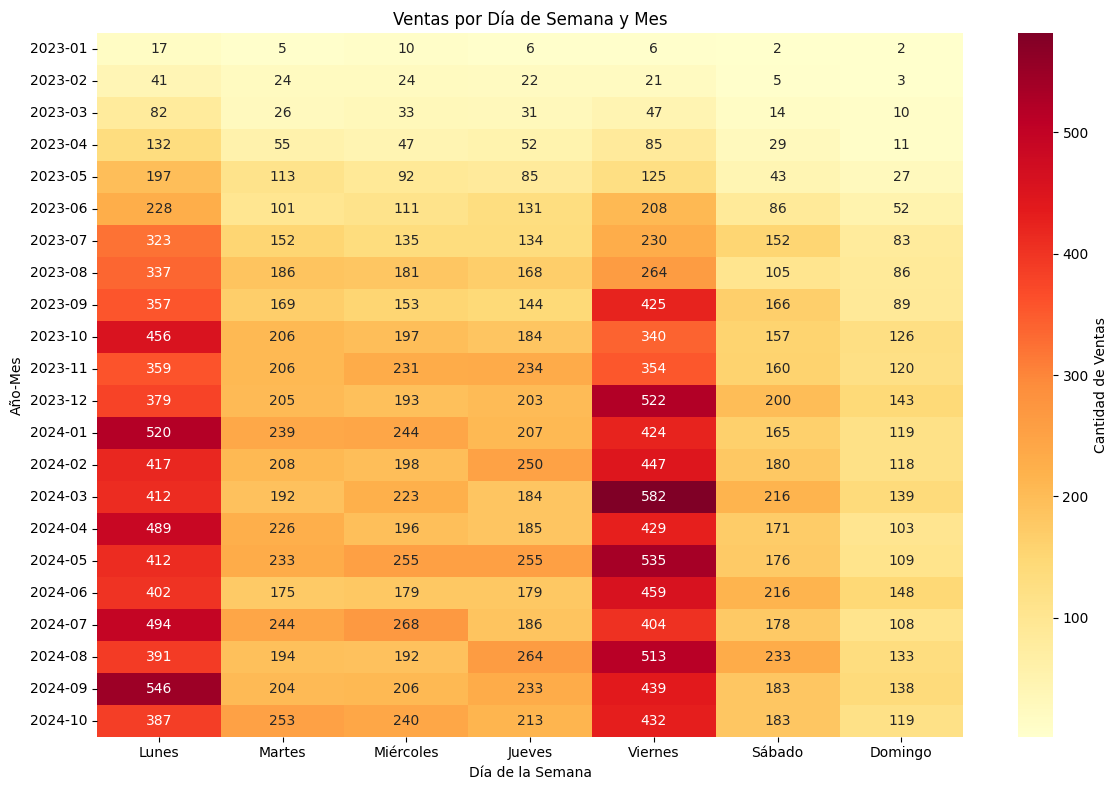

In [70]:
# Definir nombres de los días
dias_nombres = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

# Agregar ventas por mes y día de semana
ventas_heatmap = ventas_seg.groupby(['añomes', 'diasem']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(ventas_heatmap, annot=True, fmt='d', cmap='YlOrRd', 
            xticklabels=dias_nombres, cbar_kws={'label': 'Cantidad de Ventas'})
plt.title('Ventas por Día de Semana y Mes')
plt.xlabel('Día de la Semana')
plt.ylabel('Año-Mes')
plt.tight_layout()
plt.show()

Este heatmap revela patrones temporales en el comportamiento de compra del Segmento 3:

**Crecimiento y Escala:**
- **Expansión significativa**: De 48 ventas totales (enero 2023) a 1,827 ventas (octubre 2024), un incremento de **3,706%**
- **Pico absoluto**: Viernes de marzo 2024 con 582 ventas
- **Aceleración notable**: Los meses de 2024 muestran volúmenes consistentemente superiores a 2023
- **Volumen intermedio**: Genera ~48% de las ventas del Segmento 0 (Aurelion) a pesar de tener solo 7% de sus clientes (61 vs 881)

**Patrón Semanal Pronunciado:**
- **Lunes y Viernes dominan**: Representan ~45-50% de ventas semanales, con Lunes alcanzando hasta 546 ventas
- **Viernes especialmente fuerte**: Consistentemente el día con mayor actividad, con picos recurrentes de 400-582 ventas
- **Domingo es el día más débil**: Mantiene volúmenes bajos (~100-150 ventas), aproximadamente 25% del día pico
- **Mid-week moderado**: Martes-Jueves muestran volúmenes intermedios (~200-270 ventas)

**Correlación Temporal:**
- Todos los días crecen simultáneamente, indicando que factores externos (estacionalidad, campañas) impactan uniformemente
- Las proporciones relativas se mantienen: Lunes/Viernes ~3.5x Domingo
- Crecimiento sostenido incluso con base de clientes estancada (61 desde nov-2023)

### Evolución de Ventas Diarias por Día de Semana

In [71]:
fecha_corte = pd.to_datetime('2024-10-31')

ventas_dia = ventas_seg.groupby([pd.to_datetime(ventas_seg['fecha']).dt.date, 'diasem']).size().reset_index(name='ventas')
ventas_dia['fecha'] = pd.to_datetime(ventas_dia['fecha'])
ventas_dia['dia_nombre'] = ventas_dia['diasem'].map(dict(enumerate(dias_nombres)))

fig = px.scatter(ventas_dia, x='fecha', y='ventas', color='dia_nombre',
                 facet_col='dia_nombre', facet_col_wrap=4,  # ✅ Cambio aquí
                 title='Evolución de Ventas Diarias por Día de Semana (2023-2024)',
                 labels={'ventas': 'Cantidad de Ventas', 'fecha': 'Fecha'},
                 category_orders={'dia_nombre': dias_nombres},  # ✅ Orden por nombres
                 height=800)

# Agregar línea vertical en todos los subgráficos
fig.add_vline(x=fecha_corte, line_dash="dash", line_color="red", 
              line_width=2, opacity=0.7)

fig.update_layout(showlegend=False)

fig.show()

Este gráfico muestra la evolución diaria de ventas segmentada por día de semana. Se observa:

- **Crecimiento inicial rápido seguido de estabilización**: Todos los días muestran crecimiento explosivo durante 2023, alcanzando un plateau desde mediados-finales de 2023 hasta 2024
- **Correlación fuerte en fase de crecimiento**: Durante 2023, cuando un día subía, TODOS los días subían simultáneamente, respondiendo a factores comunes (expansión, campañas, temporada)
- **Plateau sincronizado**: Todos los días se estabilizan simultáneamente desde finales de 2023, coincidiendo con el plateau de 61 clientes alcanzado en nov-2023
- **Patrón semanal en meseta**: Lunes (~80-120 ventas) y Viernes (~90-130 ventas) dominan claramente, Domingo (~20-40 ventas) es el más débil. Proporciones: Lunes/Viernes ~3-4x Domingo
- **Modelo B2B de alto valor**: El patrón muestra clientes corporativos con compras concentradas inicio/fin de semana
- **Línea roja (25-Oct-2024)**: Marca de referencia. El patrón de plateau se mantiene estable antes de esta fecha

La **correlación inicial y posterior estabilización** indica que el segmento alcanzó su **capacidad óptima** tanto en clientes (61) como en volumen de ventas por día. El plateau no es negativo sino indicador de **madurez y estabilidad operativa**, con ventas predecibles que permiten planificación eficiente.

### Estrategias

Objetivo Estratégico: Máxima Retención (Cero Fugas) y Aumento del Ticket Promedio aprovechando el patrón de compra concentrado (Lunes/Viernes).

**Estrategia 1:** Programa de Defensa Anti-Competencia

Tácticas de Marketing Adaptadas (Alineadas con el Contexto): "Garantía de Lealtad en Días Pico": Ofrecer un beneficio superior (ej. envío gratuito o 10% de descuento solo en Viernes, su día pico de gasto) para asegurar que el cliente siempre elija Los Latinos para su gran compra semanal.

Justificación (Basada en los Gráficos): El Viernes es el día más fuerte (pico de 582 ventas). Esto defiende el gasto crucial del fin de semana/reabastecimiento y hace muy costoso para el cliente ir a la competencia ese día.

**Estrategia 2:** Servicio Premium de Comodidad

Tácticas de Marketing Adaptadas (Alineadas con el Contexto): Servicio de Pedido Anticipado/Fast Lane: Implementar un sistema de WhatsApp o una Fast Lane de pago dedicada a los Fieles para gestionar sus grandes pedidos de Lunes y Viernes sin esperas.

Justificación (Basada en los Gráficos): Dada su alta frecuencia (casi diaria) y el patrón B2B/alto valor, su tiempo es valioso. Reducir la fricción en el proceso de compra es una forma de fidelización inestimable.

**Estrategia 3:** Monitoreo y Upselling de Alta Gama

Tácticas de Marketing Adaptadas (Alineadas con el Contexto): Recomendación de Novedades Premium: Asignar un miembro del staff para comunicar novedades de productos de alto margen y valor (gourmet, importados exclusivos) directamente por WhatsApp a estos 61 clientes, antes que a nadie.

Justificación (Basada en los Gráficos): El objetivo no es aumentar la frecuencia (que ya es máxima), sino el Valor Monetario (V) por transacción, introduciendo productos de mayor precio.

**Estrategia 4:** Aprovechamiento de la Estabilidad

Tácticas de Marketing Adaptadas (Alineadas con el Contexto): Planificación de Inventario Predictiva: Utilizar la estabilidad perfecta del plateau para predecir con alta precisión qué productos comprarán Lunes y Viernes. Ofrecer esos productos con cross-selling personalizado justo antes de su día de compra.

Justificación (Basada en los Gráficos): Su compra es predecible y estable. Esto permite optimizar el stock para ellos y ofrecer promociones de bundle de alta rentabilidad.

Conclusión Ajustada:
El Cluster 3 es un grupo maduro y saturado en cuanto a volumen de clientes, pero es el más rentable. La estrategia debe ser Retención por Servicio y Aumento de Valor por la Vía Premium. La inversión debe ser alta, pero enfocada en la comodidad y la recompensa, utilizando los días clave (Lunes y Viernes) para blindar su lealtad frente a la competencia.

